# Práctica 2 - Generación de imágenes

Un autoencoder es una red de neuronas que está entrenada para intentar reproducir su entrada en la salida. Internamente consta de tres partes:
 1. Una red codificadora que obtiene un vector $\mathbf{h}$, de menor tamaño que la entrada.
 $$
 \mathbf{h}=f(\mathbf{x})
 $$
 $\mathbf{h}$ constituye una representación latente de la entrada. Esta representación latente debe contener la información de la entrada original para poder reconstruirla.
 1. Una red decodificadora que, a partir de $\mathbf{h}$, produce $\mathbf{\hat{x}}$.
 $$
 \mathbf{\mathbf{\hat{x}}}=f(\mathbf{h})
 $$
 El autoencoder al completo se entrenará para que $\mathbf{\hat{x}}$ reproduzca $\mathbf{x}$, para lo cual el vector $\mathbf{h}$ deberá contener la información contenida en $\mathbf{x}$, a pesar de ser de un tamaño mucho menor.

 ![Esquema de la arquitectura de un autoencoder](https://drive.google.com/uc?export=view&id=1I4IfrsCJDWBDiGYlUNGr4M-IP7Ehb2Mr)

## Tarea a realizar
Diseña un autoencoder convolucional que sea capaz de reconstruir imágenes y, en el proceso, aprenda a representar las imágenes originales en un espacio latente de dimensión reducida.

### Preparativos
Utilizaremos el dataset MNIST, del que solo necesitaremos las entradas (desechamos las etiquetas). Además, podemos aprovechar tanto el conjunto de train como el de test para el entrenamiento.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Pasos a seguir

### Diseño de la arquitectura
  - Diseña una red convolucional que actúe de encoder. Debe tener alguna capa convolucional. La salida de este autoencoder será un vector con `dimension_h` componentes. En esta práctica tomaremos siempre `dimension_h`=2.

In [ ]:

dimension_h = 2

encoder = keras.Sequential()
encoder.add(keras.Input(shape=(28, 28, 1)))
encoder.add(keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"))
encoder.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
encoder.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
encoder.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
encoder.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
encoder.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
encoder.add(keras.layers.Flatten())
encoder.add(keras.layers.Dense(dimension_h))

encoder.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,346 (99.01 KB)

 Trainable params: 25,346 (99.01 KB)

 Non-trainable params: 0 (0.00 B)

  - Diseña una red convolucional que actúe de decoder. Su arquitectura será similar a la del encoder, pero utilizando capas complementarias a las convolucionales [(Conv2DTranspose)](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/). La entrada a este decoder será un vector de tamaño dimension_latente. La salida tendrá la misma shape que la entrada del encoder.

In [ ]:
dimension_h = 2

decoder = keras.Sequential()
decoder.add(keras.Input(shape=(dimension_h,)))
decoder.add(keras.layers.Dense(units=7 * 7 * 64, activation="relu"))
decoder.add(keras.layers.Reshape(target_shape=(7, 7, 64)))
decoder.add(keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
decoder.add(keras.layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same"))
decoder.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=1, activation="sigmoid", padding="same"))

decoder.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                     │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_15 (Reshape)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_37                  │ (None, 14, 14, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_38                  │ (None, 28, 28, 16)          │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_39                  │ (None, 28, 28, 1)           │             145 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,641 (127.50 KB)

 Trainable params: 32,641 (127.50 KB)

 Non-trainable params: 0 (0.00 B)

  - Diseña el modelo del autoencoder completo concatenando el encoder y el decoder.
  - Compila el modelo indicando un optimizador y función de pérdida que consideres apropiados.

In [ ]:
autoencoder = keras.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
autoencoder.summary()

autoencoder.compile(optimizer="adam", loss="mean_squared_error")

Model: "functional_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 2)                   │           2,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_24 (Sequential)           │ (None, 28, 28, 1)           │          32,641 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,987 (226.51 KB)

 Trainable params: 57,987 (226.51 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento
  - Entrena el modelo completo durante 30 epochs. Especifica un tamaño de lote de 128. Presta atención a la función de coste a utilizar.

In [ ]:
autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 85s 152ms/step - loss: 0.0882
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 142s 152ms/step - loss: 0.0496
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 143s 154ms/step - loss: 0.0463
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 83s 151ms/step - loss: 0.0446
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 169s 201ms/step - loss: 0.0433
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 85s 154ms/step - loss: 0.0428
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 86s 156ms/step - loss: 0.0423
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 142s 156ms/step - loss: 0.0417
Epoch 9/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 139s 151ms/step - loss: 0.0416
Epoch 10/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 142s 152ms/step - loss: 0.0412
Epoch 11/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 144s 155ms/step - loss: 0.0406
Epoch 12/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 140s 152ms/step - loss: 0.0405
Epoch 13/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 143s 154ms/step - loss: 0.0404
Epoch 14/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 141s 152ms/step - loss: 0.0399
Epoch

- Vuelve al principio y revisa la arquitectura o el método de aprendizaje hasta conseguir un resultado que no puedas mejorar fácilmente.

¡Tu modelo ya está entrenado! Si todo ha ido bien, el modelo es capaz de resumir cada imagen en `dimension_h`=2 valores que contienen toda la información necesaria para reconstruir la imagen original.

Además, para cualquier par de números $(h_0,h_1)$, el decoder es capaz de generar una imagen similar a las del conjunto de entrenamiento. Podemos utilizar esta característica para generar nuevas imágenes, simplemente pasándole al encoder un par de números cualesquiera.

En lugar de probar valores aleatorios, vamos a explorar el espacio latente de manera ordenada. Para ello daremos valores entre -1 y 1 a las dos variables latentes y comprobaremos qué imagen produce el decoder cuando se le proporciona esa entrada.

In [ ]:
import matplotlib.pyplot as plt

'''
Esta función crea un entramado de nxn imágenes donde cada una es el resultado de
aplicar el decoder pasado como parámetro a un vector [x,y], donde x e y recorren el espacio entre -1 y
1 utilizando incrementos para cubrirlo uniformemente.
'''
def genera_entramado_imagenes(decoder, shape_imagen, limites_exploracion=[-1,1], escala=15, pasos=30):
    alto_imagen = shape_imagen[0]
    ancho_imagen = shape_imagen[1]

    # Tendremos un solo array donde iremos guardando las imágenes generadas
    imagen_general = np.zeros((alto_imagen * pasos, ancho_imagen * pasos))

    h = []

    for i in range(pasos):
        for j in range(pasos):
            # Calculamos el valor h para pasarle al decoder
            h0 = limites_exploracion[0] + (limites_exploracion[1]-limites_exploracion[0])*i/pasos
            h1 = limites_exploracion[0] + (limites_exploracion[1]-limites_exploracion[0])*j/pasos
            h.append([h0, h1])

    h = np.array(h)
    # Generamos la imagen a partir de los valores h
    imagen_generada = decoder.predict(h, verbose=0).reshape(-1, alto_imagen, ancho_imagen)

    c = 0
    for i in range(pasos):
        for j in range(pasos):
            # Guardamos la imagen en la imagen general
            imagen_general[i * alto_imagen : (i+1) * alto_imagen, j * ancho_imagen : (j+1) * ancho_imagen] = imagen_generada[c]
            c+=1

    # Mostramos un plot con la imagen general
    plt.figure(figsize=(escala, escala))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlabel("h0")
    plt.ylabel("h1")
    plt.imshow(imagen_general, cmap="Greys_r")
    plt.show()

  - Lanza la función para que explore el espacio con tu decoder.

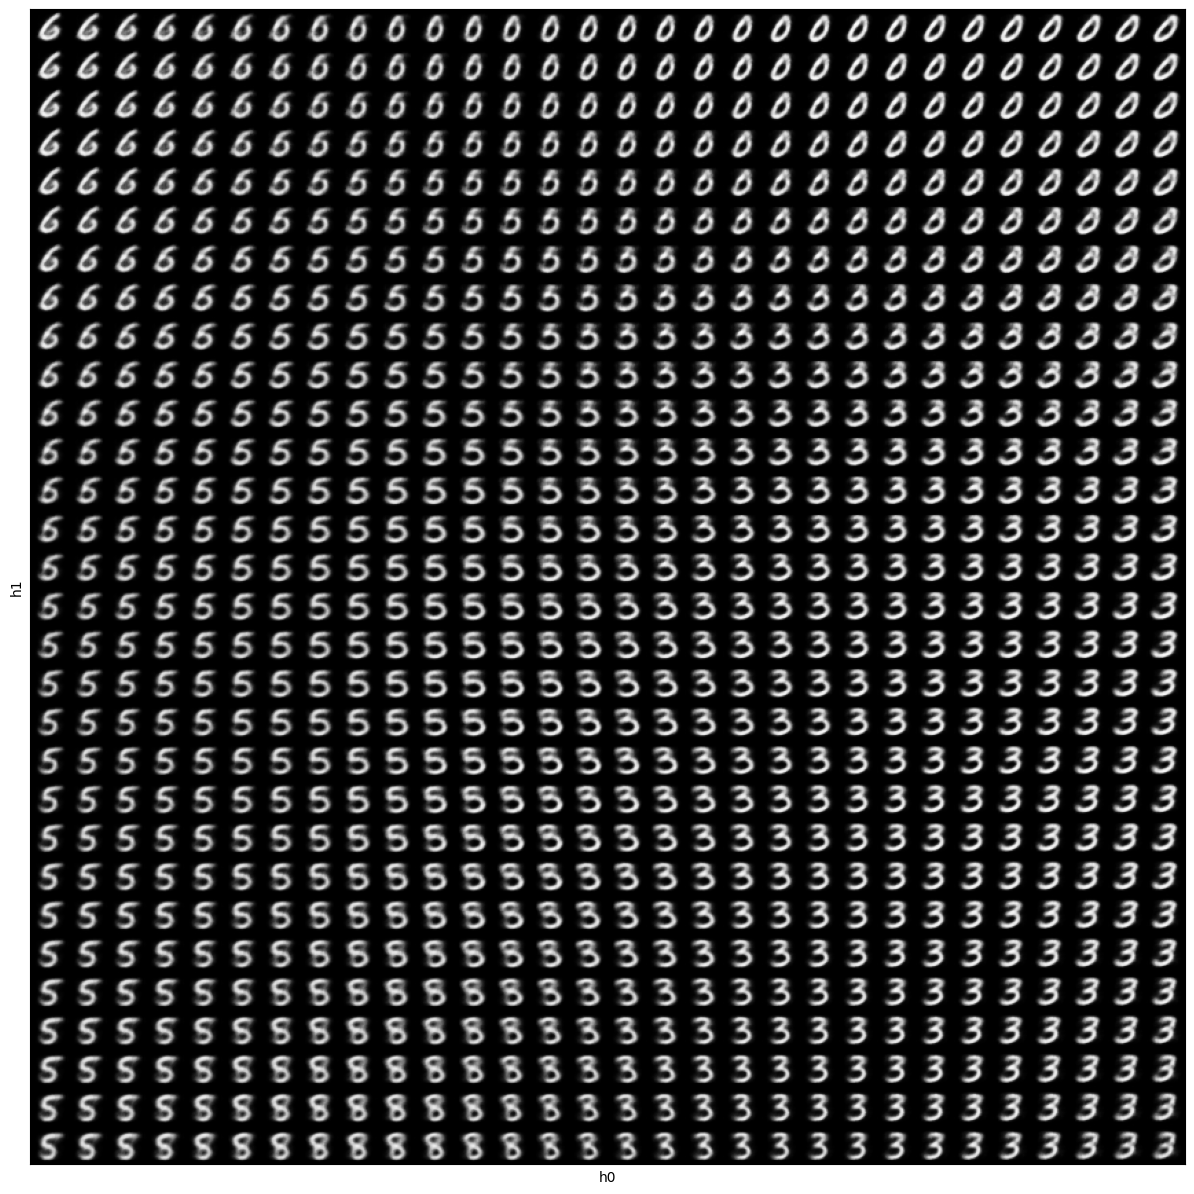

In [ ]:
genera_entramado_imagenes(decoder, (28, 28))

Puedes comprobar que, aunque hay muchas imágenes que representan números correctamente, hay grandes regiones del espacio latente que producen imágenes sin sentido. Esto es así porque los espacios aprendidos por los autoencoder no tienen por qué ser continuos. Para obtener un autoencoder que favorezca este tipo de exploración tenemos que añadir una restricción que fuerce a que el espacio latente tenga una forma determinada.

## Mejora de la explorabilidad del espacio latente
Diseña un nuevo autoencoder con una restricción adicional: **cada variable $h_i$ de la representación latente debe seguir una distribución gaussiana**.

Para ello, por cada variable latente, el encoder producirá dos escalares, $hm_i$ y $hs_i$ que harán las veces de media y desviación típica de dicha variable latente. Con estos parámetros, se tomará una muestra aleatoria de cada distribución para obtener el vector latente que sirva de entrada al decoder.

$$h_i \sim N(hm_i, hs_i)$$

Utiliza la funcion `tf.keras.backend.random_normal`, que muestrea números $z \sim N(0, 1)$ a partir del cual puedes generar $h_i$ como $h_i=hm_i + z*hs_i$

Nota: Por razones de estabilidad numérica, puede ser conveniente que tomes $hs_i$ como el logaritmo de la varianza, en lugar de como la desviación típica. En ese caso, puedes generar $h_i$ así: $$h_i=hm_i + z*e^{(hs_i/2)}$$

![Esquema de la arquitectura de un autoencoder](https://drive.google.com/uc?export=view&id=1i7ADJ0ilUk-lqYa_Qv9_b2sIVJkx_aaS)

## Pasos a seguir

### Diseño de la arquitectura
  - Diseña un nuevo encoder. También debe tener alguna capa convolucional, pero ahora las salidas de este autoencoder serán 2 * dimension_latente valores escalares.

In [ ]:
dimension_h = 2

encoder_mejorado = keras.Sequential()
encoder_mejorado.add(keras.Input(shape=(28, 28, 1)))
encoder_mejorado.add(keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"))
encoder_mejorado.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
encoder_mejorado.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
encoder_mejorado.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
encoder_mejorado.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
encoder_mejorado.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
encoder_mejorado.add(keras.layers.Flatten())
encoder_mejorado.add(keras.layers.Dense(2 * dimension_h))
hm = encoder_mejorado.outputs[0][:, :dimension_h]
hs = encoder_mejorado.outputs[0][:, dimension_h:]
encoder_mejorado = keras.Model(inputs=encoder_mejorado.inputs, outputs=[hm, hs])
encoder_mejorado.summary()

Model: "functional_373"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_53            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 28, 28, 16)     │            160 │ input_layer_53[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_78          │ (None, 14, 14, 16)     │              0 │ conv2d_78[7][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 14, 14, 32)     │          4,640 │ max_pooling2d_78[6][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_79          │ (None, 7, 7, 32)       │              0 │ conv2d_79[5][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 7, 7, 64)       │         18,496 │ max_pooling2d_79[4][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_80          │ (None, 4, 4, 64)       │              0 │ conv2d_80[3][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_26 (Flatten)      │ (None, 1024)           │              0 │ max_pooling2d_80[2][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 4)              │          4,100 │ flatten_26[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_52 (GetItem)     │ (None, 2)              │              0 │ dense_53[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_53 (GetItem)     │ (None, 2)              │              0 │ dense_53[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,396 (107.02 KB)

 Trainable params: 27,396 (107.02 KB)

 Non-trainable params: 0 (0.00 B)

  - Diseña una capa que, a partir de las medias hm y desviaciones hs de cada variable, genere el vector h.

In [ ]:
class Muestrea(keras.layers.Layer):
    """Tomando hm y hs, muestrea h según la ecuación mostrada arriba (h = hm + z * e ^ (hs / 2), donde z ~ N(0, 1))"""

    def call(self, inputs):
        hm, hs = inputs
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(hm)[0], tf.shape(hm)[1]))
        return hm + tf.exp(0.5 * hs) * epsilon

  - Haz los cambios que consideres pertinentes en el decoder.

In [ ]:
decoder_mejorado = keras.Sequential()
decoder_mejorado.add(keras.Input(shape=(dimension_h,)))
decoder_mejorado.add(keras.layers.Dense(units=7 * 7 * 64, activation="relu"))
decoder_mejorado.add(keras.layers.Reshape(target_shape=(7, 7, 64)))
decoder_mejorado.add(keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
decoder_mejorado.add(keras.layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same"))
decoder_mejorado.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=1, activation="sigmoid", padding="same"))

decoder_mejorado.summary()

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                     │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_27 (Reshape)                 │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_78                  │ (None, 14, 14, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_79                  │ (None, 28, 28, 16)          │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_80                  │ (None, 28, 28, 1)           │             145 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,641 (127.50 KB)

 Trainable params: 32,641 (127.50 KB)

 Non-trainable params: 0 (0.00 B)

  - Diseña el modelo completo y altera el train_step para que la función de pérdida, además del error de reconstrucción, tenga en cuenta la KL-divergence con una N(0,1)
  - La fórmula para la KL-divergence entre dos distribuciones $p=N(\mu_1,\sigma_1)$ y $q=N(\mu_2,\sigma_2)$ es la siguiente:
  $$KL(p,q) = \log{\frac{\sigma_2}{\sigma_1}}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$

In [ ]:
from tensorflow.keras.models import Model

class EncoderMejorado(keras.Model):
    def __init__(self, encoder, decoder, muestrea, **kwargs):
        super(EncoderMejorado, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.muestrea = muestrea


    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            hm, hs = self.encoder(data)
            h = self.muestrea([hm, hs])
            reconstruction = self.decoder(h)
            # Calculo de la pérdida
            loss = tf.reduce_mean(keras.losses.MSE(data, reconstruction))
            # Añadimos la divergencia KL
            kl_loss = -0.5 *tf.reduce_mean(1 + hs - tf.square(hm) - tf.exp(hs))
            loss_total = loss + kl_loss*0.001
        grads = tape.gradient(loss_total, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights + self.decoder.trainable_weights))
        return {'loss': loss, 'kl_loss': kl_loss, 'total_loss': loss_total}

  - Entrena el modelo

In [ ]:
autoencoder_mejorado = EncoderMejorado(encoder_mejorado, decoder_mejorado, Muestrea())
autoencoder_mejorado.compile(optimizer="adam")

autoencoder_mejorado.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - kl_loss: 1.9523 - loss: 0.0638 - total_loss: 0.0657
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.3393 - loss: 0.0484 - total_loss: 0.0507
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.5715 - loss: 0.0453 - total_loss: 0.0479
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 2.6835 - loss: 0.0438 - total_loss: 0.0465
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.7476 - loss: 0.0428 - total_loss: 0.0455
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.8204 - loss: 0.0422 - total_loss: 0.0450
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.8523 - loss: 0.0416 - total_loss: 0.0445
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 2.8920 - loss: 0.0412 - total_loss: 0.0441
Epoch 9/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - kl_loss: 2.9213 - loss: 0.0409 - total_loss: 0.0438
Epoch 10/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5

  - Explora el espacio latente con este nuevo decoder

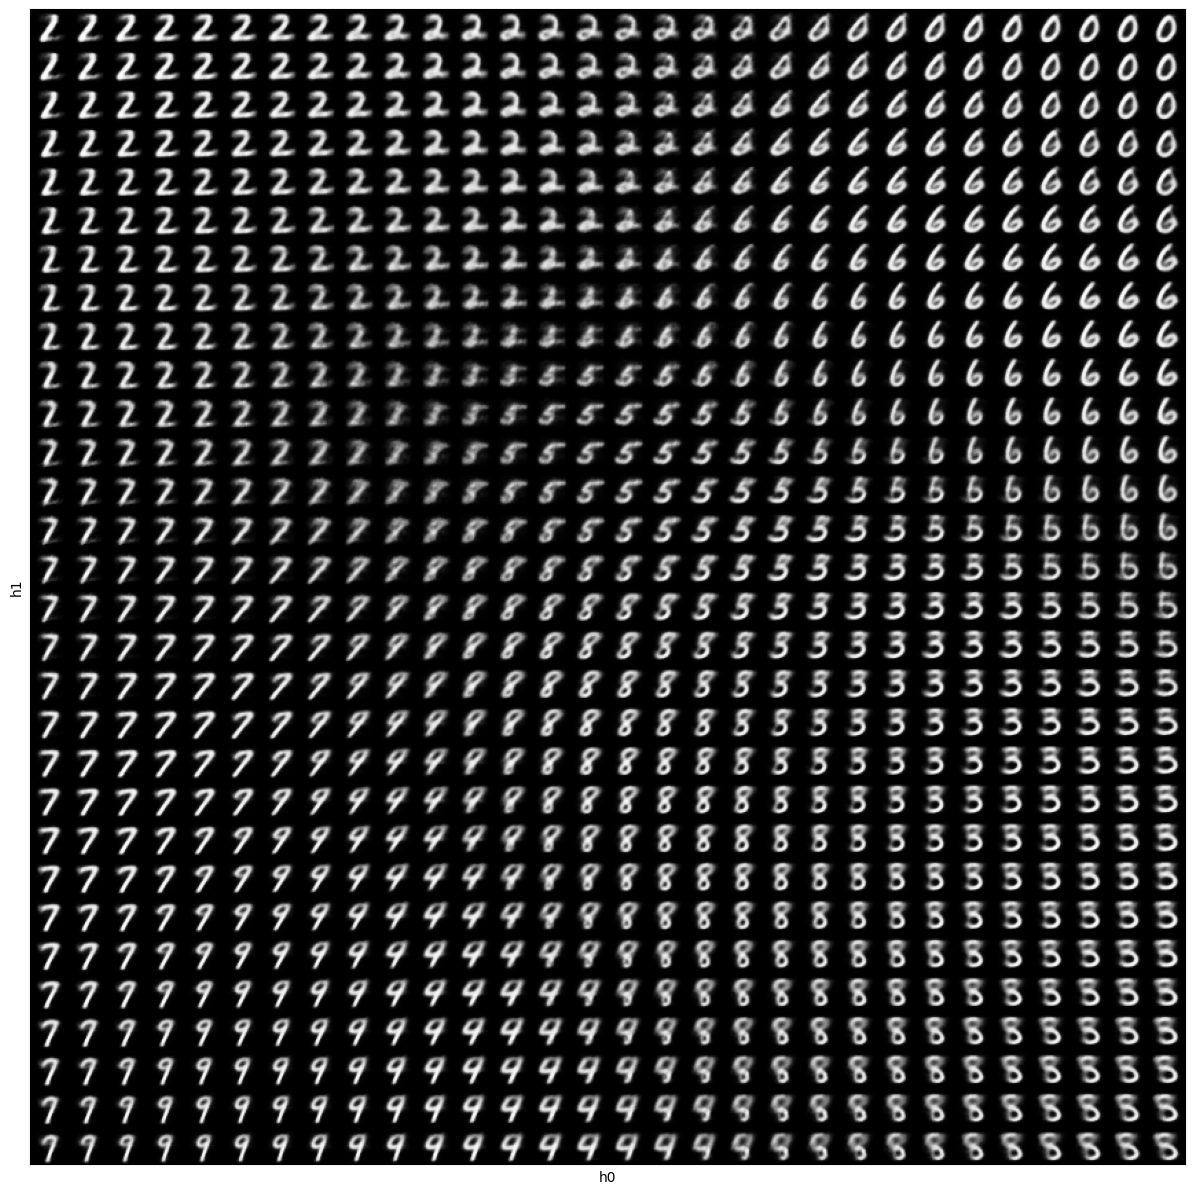

In [ ]:
genera_entramado_imagenes(decoder_mejorado, shape_imagen=(28, 28))

# Adaptación a otro conjunto de datos

Modifica tu generador de imágenes para que funcione con el conjunto de datos CIFAR10.

In [1]:
from tensorflow import keras
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
cifar10_images = np.concatenate([x_train, x_test], axis=0)
cifar10_images = cifar10_images.astype("float32") / 255

# Comprobamos el tamaño de las imágenes
print(cifar10_images.shape) # (60000, 32, 32, 3)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
(60000, 32, 32, 3)


In [4]:
dimension_h = 128

encoder = keras.Sequential()
encoder.add(keras.Input(shape=(32, 32, 3)))
encoder.add(keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"))
encoder.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
encoder.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
encoder.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
encoder.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
encoder.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
encoder.add(keras.layers.Flatten())
encoder.add(keras.layers.Dense(2*dimension_h))
hm = encoder.outputs[0][:, :dimension_h]
hs = encoder.outputs[0][:, dimension_h:]
encoder = keras.Model(inputs=encoder.inputs, outputs=[hm, hs])

encoder.summary()

decoder = keras.Sequential()
decoder.add(keras.Input(shape=(dimension_h,)))
decoder.add(keras.layers.Dense(units=8 * 8 * 64, activation="relu"))
decoder.add(keras.layers.Reshape(target_shape=(8, 8, 64)))
decoder.add(keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
decoder.add(keras.layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same"))
decoder.add(keras.layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same"))

decoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 16)     │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 16)     │              0 │ conv2d[7][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 32)     │          4,640 │ max_pooling2d[6][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 32)       │              0 │ conv2d_1[5][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ max_pooling2d_1[4][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 4, 4, 64)       │              0 │ conv2d_2[3][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1024)           │              0 │ max_pooling2d_2[2][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        262,400 │ flatten[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 128)            │              0 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 285,984 (1.09 MB)

 Trainable params: 285,984 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 4096)                │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │             435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 551,907 (2.11 MB)

 Trainable params: 551,907 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
import tensorflow as tf

class Muestrea(keras.layers.Layer):
    """Tomando hm y hs, muestrea h según la ecuación mostrada arriba (h = hm + z * e ^ (hs / 2), donde z ~ N(0, 1))"""

    def call(self, inputs):
        hm, hs = inputs
        x = tf.shape(hm)[0]
        y = tf.shape(hm)[1]
        epsilon = tf.keras.backend.random_normal(shape=(x, y))
        return hm + tf.exp(0.5 * hs) * epsilon

In [5]:
autoencoderCIFAR = EncoderMejorado(encoder, decoder, Muestrea())
autoencoderCIFAR.compile(optimizer="adam")

autoencoderCIFAR.fit(cifar10_images, epochs=30, batch_size=128)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - kl_loss: 1.1202 - loss: 0.0278 - total_loss: 0.0289
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - kl_loss: 1.5681 - loss: 0.0127 - total_loss: 0.0143
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 1.6152 - loss: 0.0109 - total_loss: 0.0125
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 1.6510 - loss: 0.0098 - total_loss: 0.0114
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 1.6662 - loss: 0.0091 - total_loss: 0.0107
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 1.6793 - loss: 0.0086 - total_loss: 0.0103
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 1.6847 - loss: 0.0082 - total_loss: 0.0099
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 1.6898 - loss: 0.0079 - total_loss: 0.0096
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 1.6947 - loss: 0.0077 - total_loss: 0.0094
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


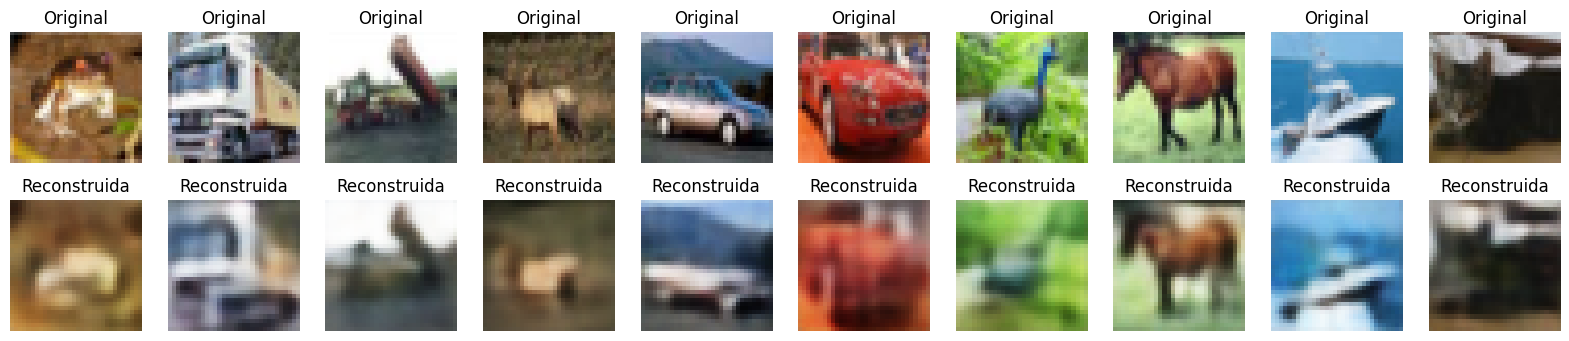

In [6]:
# Comparamos las imágenes originales con las reconstruidas
import numpy as np
import matplotlib.pyplot as plt

# Número de imágenes para comparar
n = 10
imagenes_originales = cifar10_images[:n]

# Paso por el encoder para obtener hm y hs
hm, hs = autoencoderCIFAR.encoder.predict(imagenes_originales)

# Aplicamos la función de muestreo para obtener h
h = autoencoderCIFAR.muestrea([hm, hs])

# Reconstruimos las imágenes usando el decoder
imagenes_reconstruidas = autoencoderCIFAR.decoder.predict(h)

# Comparación visual
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imagenes_originales[i])
    plt.title("Original")
    ax.axis('off')

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imagenes_reconstruidas[i])
    plt.title("Reconstruida")
    ax.axis('off')

plt.show()

### Probamos a generar imágenes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


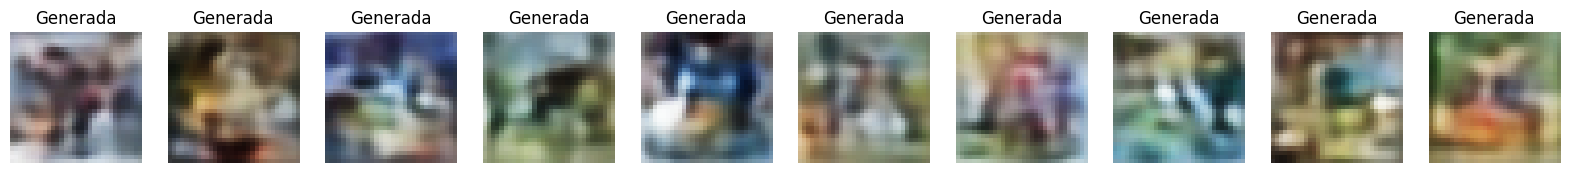

In [10]:
# Generamos nuestras propias imágenes
dimension_h = 128

h = np.random.normal(size=(10, dimension_h))
imagenes_generadas = autoencoderCIFAR.decoder.predict(h)

plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(imagenes_generadas[i])
    plt.title("Generada")
    ax.axis('off')
plt.show()